# Experiment Analysis Notebook (Aligned with report_from_results.py)

This notebook analyzes simulation experiment results, mirroring the analyses performed by `analysis/report_from_results.py`.
Key features:
- Dynamically select the experiment directory.
- Load and preprocess data from `design_table.csv`.
- Generate visualizations and regression analyses.

## 1. Setup and Configuration

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import json
import re
import textwrap
import statsmodels.formula.api as smf

# --- Add project root to sys.path if needed for analysis package --- 
import sys
SCRIPT_DIR_NOTEBOOK = os.getcwd() # Should be 'notebooks' directory
PROJECT_ROOT_NOTEBOOK = os.path.abspath(os.path.join(SCRIPT_DIR_NOTEBOOK, os.pardir))
if PROJECT_ROOT_NOTEBOOK not in sys.path:
    sys.path.insert(0, PROJECT_ROOT_NOTEBOOK)
    print(f"Added to sys.path: {PROJECT_ROOT_NOTEBOOK}")

try:
    from analysis.prediction_error_utils import calculate_and_add_prediction_errors
    print("Successfully imported calculate_and_add_prediction_errors.")
except ImportError as e:
    print(f"Error importing calculate_and_add_prediction_errors: {e}")
    print("Please ensure the 'analysis' package is accessible and sys.path is correct.")
    calculate_and_add_prediction_errors = None # Placeholder if import fails

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None) # Show all columns in DataFrames

print("Libraries imported successfully.")

Successfully imported calculate_and_add_prediction_errors.
Libraries imported successfully.


### 1.1 Specify Experiment Directory

Change the `EXPERIMENT_NAME` variable below to the name of the subfolder within `../experiments/` that you want to analyze.

In [13]:
# --- Configuration: Set your experiment name here ---
EXPERIMENT_NAME = "gridsearch_burn_in"  # <--- CHANGE THIS to your target experiment folder name
EXPERIMENT_NAME = "test_lasso_model"  # <--- CHANGE THIS to your target experiment folder name
# For example: "gridsearch_1", "baseline_fcfs", etc.
# ----------------------------------------------------

BASE_EXPERIMENT_PATH = os.path.join("..", "experiments") 
EXPERIMENT_DIR = os.path.join(BASE_EXPERIMENT_PATH, EXPERIMENT_NAME)

if not os.path.isdir(EXPERIMENT_DIR):
    print(f"ERROR: Experiment directory not found: {EXPERIMENT_DIR}")
    print(f"Please ensure '{EXPERIMENT_NAME}' exists in '{BASE_EXPERIMENT_PATH}' and you have run the pipeline for it.")
else:
    print(f"Target Experiment Directory: {EXPERIMENT_DIR}")

Target Experiment Directory: ../experiments/gridsearch_burn_in


## 2. Data Loading and Preprocessing

Loads `design_table.csv`, filters for completed runs, calculates derived metrics, and adds prediction errors.

In [14]:
results_df = None
design_table_path = os.path.join(EXPERIMENT_DIR, "design_table.csv")

if not os.path.exists(design_table_path):
    print(f"ERROR: design_table.csv not found in {EXPERIMENT_DIR}")
else:
    results_df = pd.read_csv(design_table_path)
    print(f"Successfully loaded: {design_table_path} (Rows: {len(results_df)}, Columns: {len(results_df.columns)})")

    # Filter for completed runs (Done == 1)
    if 'Done' in results_df.columns:
        original_rows = len(results_df)
        results_df = results_df[results_df['Done'] == 1].copy()
        print(f"Filtered for 'Done == 1'. Rows changed from {original_rows} to {len(results_df)}.")
    else:
        print("Warning: 'Done' column not found. Cannot filter for completed runs.")

    if results_df.empty:
        print("No completed runs found after filtering. Further analysis will be skipped.")
    else:
        # Calculate additional metrics
        if 'cases_arrived' in results_df.columns and 'cases_closed' in results_df.columns:
            results_df['closed_percent'] = np.where(results_df['cases_arrived'] > 0, 
                                               (results_df['cases_closed'] / results_df['cases_arrived']) * 100, 0)
            print("Calculated 'closed_percent'.")
        if 'cases_arrived' in results_df.columns and 'case_queued' in results_df.columns:
            results_df['case_queued_percent'] = np.where(results_df['cases_arrived'] > 0,
                                                    (results_df['case_queued'] / results_df['cases_arrived']) * 100, 0)
            print("Calculated 'case_queued_percent'.")
        
        # Calculate and add prediction errors
        if calculate_and_add_prediction_errors is not None:
            print("INFO: Calculating prediction error metrics...")
            try:
                results_df = calculate_and_add_prediction_errors(results_df.copy(), EXPERIMENT_DIR) # Pass a copy
                print("INFO: Prediction error metrics calculation complete.")
            except Exception as e:
                print(f"ERROR during prediction error calculation: {e}")
        else:
            print("Skipping prediction error calculation due to import failure.")

        # Display a sample of the processed DataFrame
        print("\nSample of processed results_df:")
        display(results_df.head())

Successfully loaded: ../experiments/gridsearch_burn_in/design_table.csv (Rows: 30, Columns: 50)
Filtered for 'Done == 1'. Rows changed from 30 to 30.
Calculated 'closed_percent'.
Calculated 'case_queued_percent'.
INFO: Calculating prediction error metrics...
INFO: Prediction error metrics calculation complete.

Sample of processed results_df:


,F_priority_scheme,F_number_of_agents,F_hard_ceiling,F_ceiling_value,F_burn_in,F_days,F_fit_on_burn_in,F_NPS_dist_bias,F_tNPS_wtime_effect_bias,startdate,repetition,closed_avg_simulated_NPS,closed_avg_simulated_throughput_time,closed_avg_predicted_NPS,closed_avg_predicted_throughput_time,closed_avg_predicted_NPS_priority,closed_avg_initial_delay,closed_avg_activity_start_delay,closed_avg_duration_delayed,all_avg_simulated_NPS,all_avg_simulated_throughput_time,all_avg_predicted_NPS,all_avg_predicted_throughput_time,all_avg_predicted_NPS_priority,all_avg_initial_delay,all_avg_activity_start_delay,all_avg_duration_delayed,Simulation_duration_min,dynamic_model_mae_burnin,dynamic_model_mse_burnin,dynamic_model_mae_main,dynamic_model_mse_main,cases_arrived,cases_closed,case_queued,cases_assigned_at_end,min_tracelen,max_tracelen,dynamic_model_n_burnin_samples,dynamic_model_n_main_cases,RUN,Done,Started_at,Finished_at,burnin_closed_avg_simulated_NPS,burnin_closed_avg_simulated_throughput_time,burnin_closed_avg_predicted_NPS,burnin_closed_avg_predicted_throughput_time,burnin_cases_arrived,burnin_cases_closed,closed_percent,case_queued_percent,mae_TT_pred_error,mse_TT_pred_error,rmse_TT_pred_error,mae_NPS_pred_error,mse_NPS_pred_error,rmse_NPS_pred_error
0,NPS,3,NONE,2.5,50,400,Train,0.0,-1.0,2018-07-01,0,10.707934,124.016827,6.045908,1920.482747,1.454092,120.341351,0.419797,0.419797,10.707934,124.016827,6.045908,1920.482747,1.454092,120.341351,0.419797,0.419797,25.208891,3978.261900,2.810962e+07,1796.308692,7.671840e+06,751,266,482,0,2,13,38,266,0,1,2025-06-03 09:53:21,2025-06-03 10:18:34,10.431109,19.285972,6.185690,2.438819,69.0,69.0,35.419441,64.181092,1438.998878,5.981487e+06,2445.707913,4.911499,36.969367,6.080244
1,FCFS,3,NONE,2.5,50,400,Train,0.0,-1.0,2018-07-01,0,10.743723,144.140868,6.147879,26.429418,1.352121,140.233312,0.423565,0.423565,10.743723,144.140868,6.147879,26.429418,1.352121,140.233312,0.423565,0.423565,24.387294,5140.975280,4.594349e+07,117.943154,1.733812e+04,709,237,463,0,2,11,37,237,1,1,2025-06-03 09:53:21,2025-06-03 10:17:44,10.284325,29.265022,6.062739,1.591687,79.0,79.0,33.427362,65.303244,95.832452,1.328638e+04,115.266574,4.841721,36.175336,6.014594
2,NPS,3,NONE,2.5,100,450,Train,0.0,-1.0,2018-07-01,0,10.825342,191.674279,6.165546,9303.192343,1.334454,187.832603,0.433347,0.433347,10.825342,191.674279,6.165546,9303.192343,1.334454,187.832603,0.433347,0.433347,33.919290,4275.334127,3.276295e+07,9173.012508,1.429318e+08,780,194,579,0,2,11,77,194,2,1,2025-06-03 09:53:21,2025-06-03 10:27:16,10.371481,56.087444,6.113968,1.929661,163.0,163.0,24.871795,74.230769,5047.249105,7.811934e+07,8838.514543,4.822541,35.577992,5.964729
3,FCFS,3,NONE,2.5,100,450,Train,0.0,-1.0,2018-07-01,0,10.581943,200.672939,6.155830,12621.799329,1.344170,197.027832,0.410798,0.410798,10.581943,200.672939,6.155830,12621.799329,1.344170,197.027832,0.410798,0.410798,31.224561,7153.265274,8.027854e+07,12801.652245,4.060009e+08,690,189,495,0,2,14,86,189,3,1,2025-06-03 09:53:21,2025-06-03 10:24:35,10.816214,61.412555,6.106889,1.808418,190.0,190.0,27.391304,71.739130,6287.382394,1.984033e+08,14085.570658,4.887793,36.269074,6.022381
4,NPS,3,NONE,2.5,200,550,Train,0.0,-1.0,2018-07-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.179161,15303.765768,4.582967e+08,NaN,NaN,881,0,878,0,0,0,156,0,4,1,2025-06-03 09:53:21,2025-06-03 10:52:32,10.456286,177.999668,6.230355,1.808028,449.0,429.0,0.000000,99.659478,176.195068,4.223416e+04,205.509513,4.622414,34.586126,5.880997


## 3. Metric Definitions

In [15]:
metric_definitions_path = os.path.join(PROJECT_ROOT_NOTEBOOK, "analysis", "report_metric_definitions.md")
definitions = {}
try:
    with open(metric_definitions_path, 'r') as f:
        content = f.readlines()
    pattern = re.compile(r"^\s*\*\s*\*\*`([^`]+)`\*\*:\s*(.+)$")
    for line in content:
        match = pattern.match(line.strip())
        if match:
            key = match.group(1).strip()
            description = match.group(2).strip()
            definitions[key] = description
    if definitions:
        print("Metric Definitions:")
        for key, value in definitions.items():
            print(f"  - {key}: {value}")
    else:
        print("No metric definitions found or parsed.")
except FileNotFoundError:
    print(f"Error: Metric definitions file not found at {metric_definitions_path}")
except Exception as e:
    print(f"Error parsing metric definitions file {metric_definitions_path}: {e}")

Metric Definitions:
  - closed_avg_simulated_NPS: Average Net Promoter Score for closed cases in a simulation run. Calculated based on the simulated throughput time and case topic, then averaged. (Range: -100 to 100, higher is better).
  - closed_avg_simulated_throughput_time: Average time (in simulation hours) from case creation to case closure for all cases that were closed within a simulation run. (Lower is generally better, indicating faster resolution).
  - closed_percent: The percentage of cases that arrived during a simulation run and were subsequently closed within that same run. Calculated as `(cases_closed / cases_arrived) * 100`. (Range: 0-100%, higher indicates better system throughput for arriving cases).
  - case_queued_percent: The percentage of cases that arrived during a simulation run and had to enter a queue at least once before being processed. Calculated as `(case_queued / cases_arrived) * 100`. (Range: 0-100%, lower indicates less waiting and potentially higher im

## 4. Experiment Settings

In [16]:
settings_path = os.path.join(EXPERIMENT_DIR, "settings.json")
settings_list = []
try:
    with open(settings_path, 'r') as f:
        data = json.load(f)
    print(f"Experiment Settings ({EXPERIMENT_NAME}):")
    for key, value in data.items():
        if isinstance(value, list):
            levels_str = ', '.join(map(str, value))
        else:
            levels_str = str(value)
        settings_list.append([key, levels_str])
        print(f"  - {key}: {levels_str}")
except FileNotFoundError:
    print(f"Error: settings.json not found at {settings_path}")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {settings_path}")
except Exception as e:
    print(f"Error loading or parsing settings.json: {e}")

Experiment Settings (gridsearch_burn_in):
  - F_priority_scheme: NPS, FCFS
  - F_number_of_agents: 3
  - F_hard_ceiling: NONE
  - F_ceiling_value: 2.5
  - F_burn_in: 50, 100, 200
  - F_days: 350
  - F_fit_on_burn_in: Train
  - F_NPS_dist_bias: 0
  - F_tNPS_wtime_effect_bias: -1.0
  - startdate: 2018-07-01
  - repetition: 0, 1, 2, 3, 4


## 5. Analysis and Visualizations
This section mirrors the plots and analyses from `report_from_results.py`.

### 5.1 Prediction Error Histograms

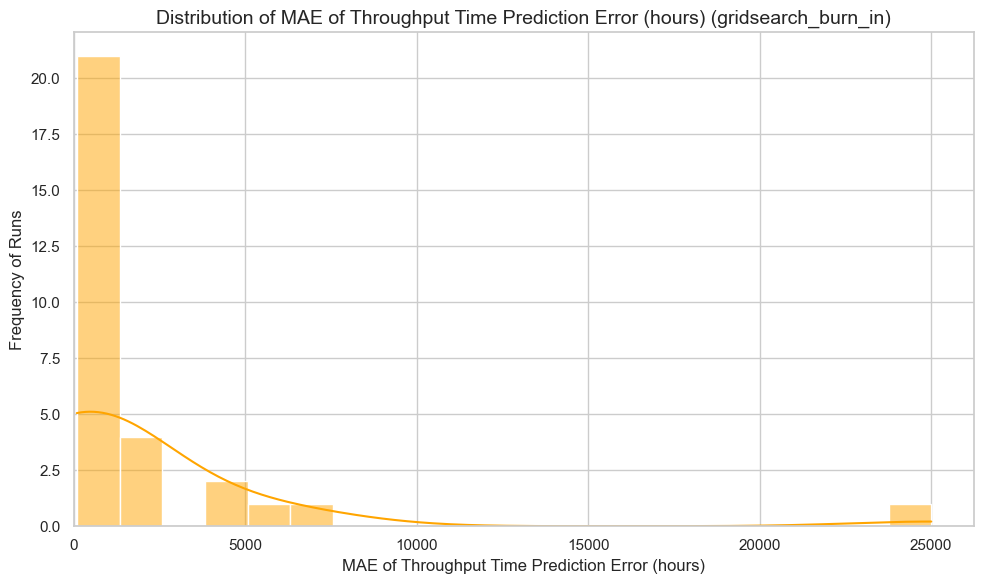

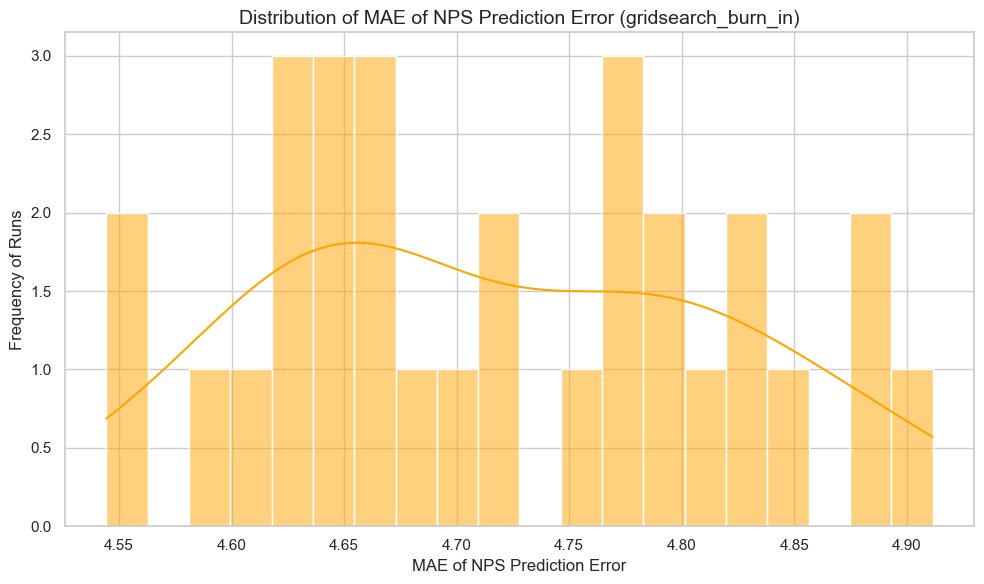

In [17]:
if results_df is not None and not results_df.empty:
    error_metrics_to_plot = {
        'mae_TT_pred_error': 'MAE of Throughput Time Prediction Error (hours)',
        'mae_NPS_pred_error': 'MAE of NPS Prediction Error'
    }

    for metric_col, label in error_metrics_to_plot.items():
        if metric_col not in results_df.columns or results_df[metric_col].isna().all():
            print(f"Warning: Column {metric_col} for histogram is missing or all NaN. Skipping histogram for '{label}'.")
            continue

        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=results_df,
            x=metric_col,
            bins=20, 
            kde=True,
            color='orange'
        )
        plt.title(f'Distribution of {label} ({EXPERIMENT_NAME})', fontsize=14)
        plt.xlabel(label, fontsize=12)
        plt.ylabel('Frequency of Runs', fontsize=12)
        current_xlim = plt.gca().get_xlim()
        if current_xlim[0] < 0 : plt.xlim(0, current_xlim[1]) # Set lower bound to 0 for MAE
        plt.tight_layout()
        plt.show()
else:
    print("Skipping Prediction Error Histograms as results_df is not available or empty.")

### 5.2 Overall Metric Comparisons (Boxplots)

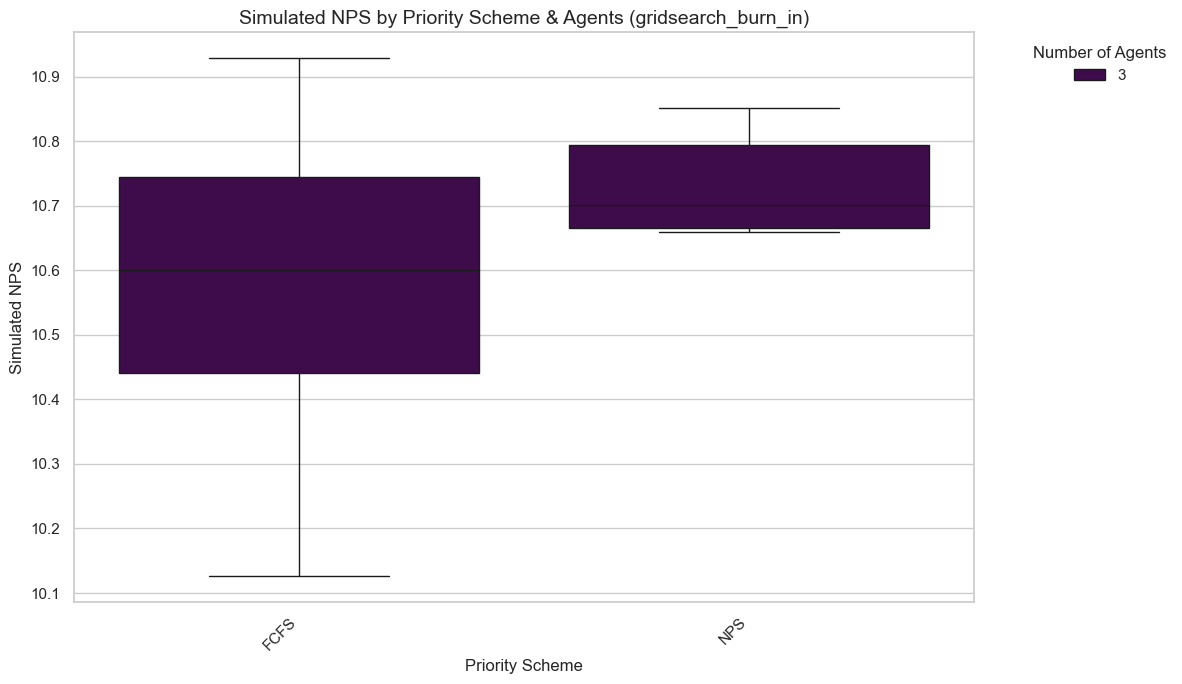

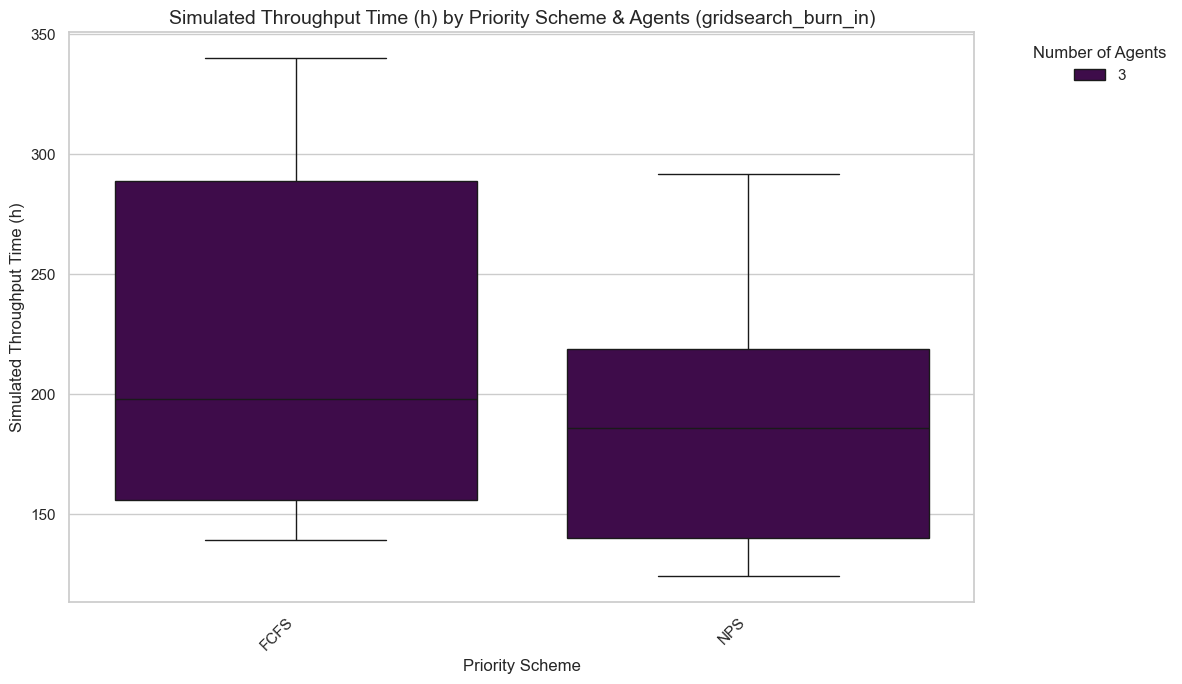

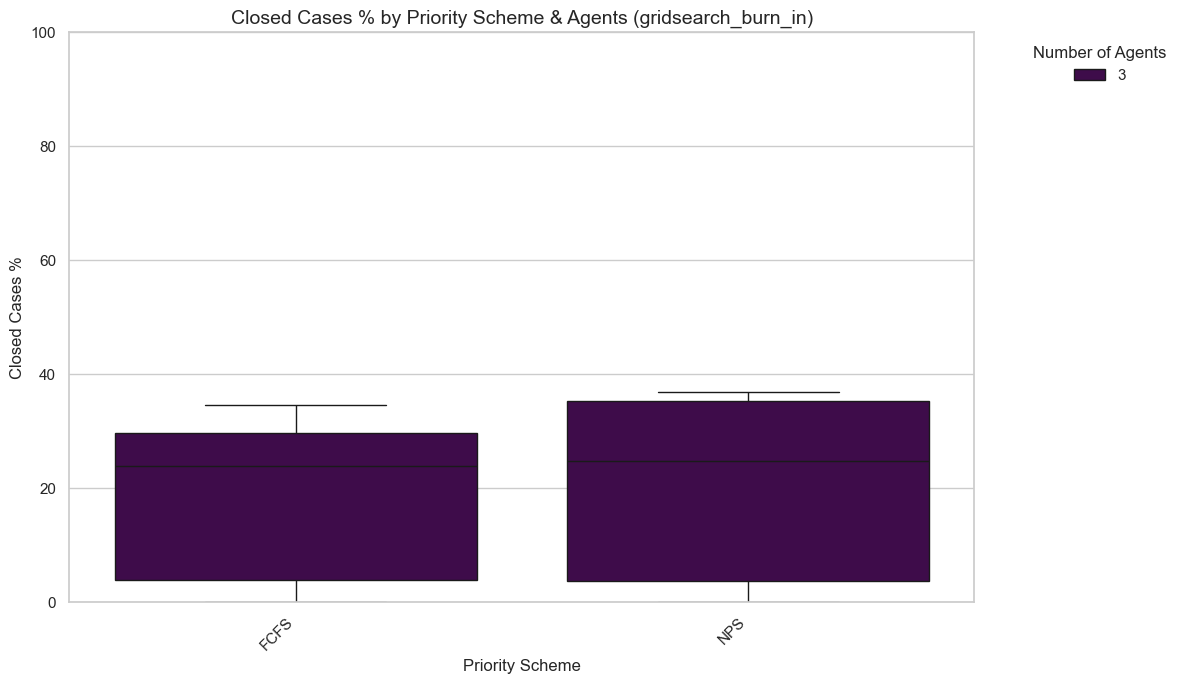

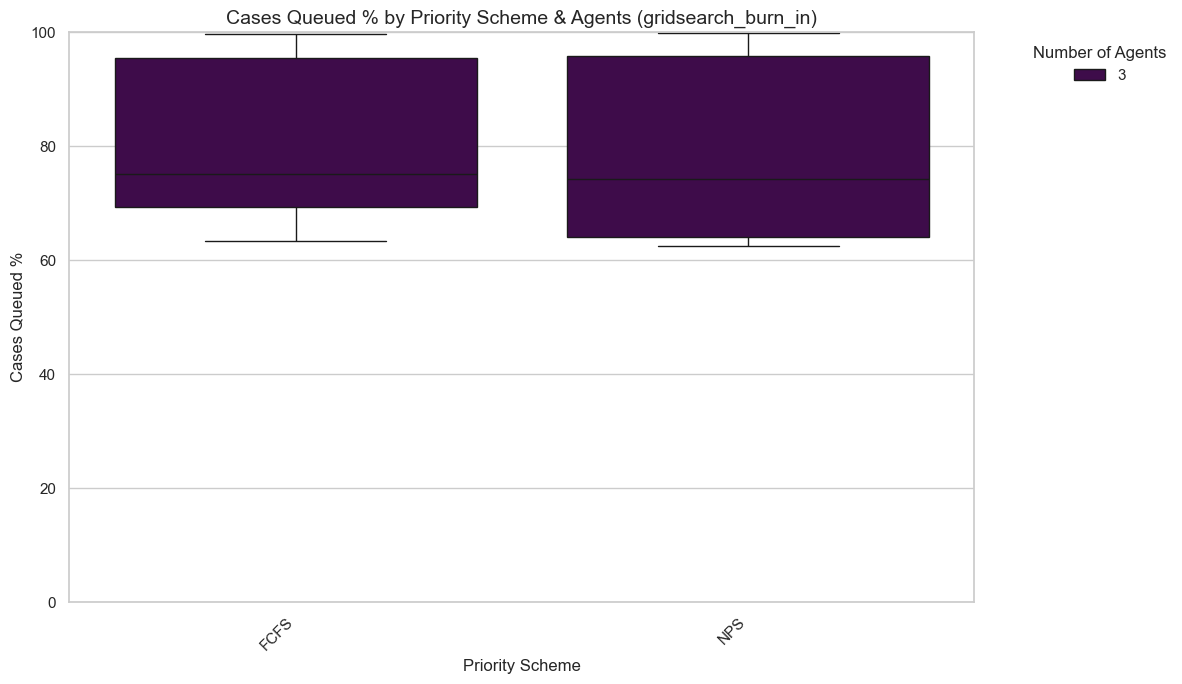

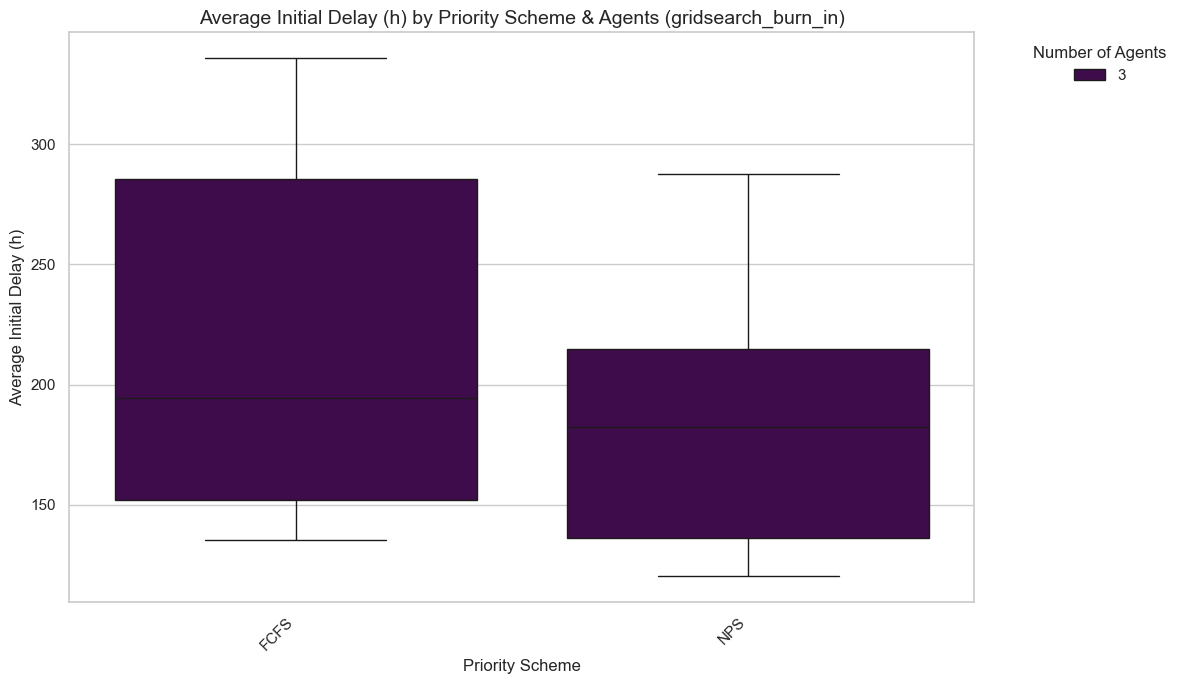

In [18]:
if results_df is not None and not results_df.empty:
    metrics_config_boxplots = {
        'closed_avg_simulated_NPS': 'Simulated NPS',
        'closed_avg_simulated_throughput_time': 'Simulated Throughput Time (h)',
        'closed_percent': 'Closed Cases %',
        'case_queued_percent': 'Cases Queued %',
        'closed_avg_initial_delay': 'Average Initial Delay (h)'
    }
    
    priority_order = ['FCFS', 'LRTF', 'SRTF', 'NPS']
    if 'F_priority_scheme' in results_df.columns:
      available_schemes_in_data = sorted(results_df['F_priority_scheme'].unique())
      ordered_schemes_for_plot = [s for s in priority_order if s in available_schemes_in_data]
      for s in available_schemes_in_data: # Add any extras not in defined order
          if s not in ordered_schemes_for_plot: ordered_schemes_for_plot.append(s)
    else:
      ordered_schemes_for_plot = []
      print("Warning: 'F_priority_scheme' column not found for ordering plots.")

    for metric, label in metrics_config_boxplots.items():
        if metric not in results_df.columns:
            print(f"Warning: Column {metric} not found. Skipping boxplot for '{label}'.")
            continue
        if results_df[metric].isna().all():
            print(f"Warning: Column {metric} is all NaN. Skipping boxplot for '{label}'.")
            continue
            
        plt.figure(figsize=(12, 7))
        sns.boxplot(
            data=results_df,
            x='F_priority_scheme',
            y=metric,
            hue='F_number_of_agents' if 'F_number_of_agents' in results_df.columns else None,
            order=ordered_schemes_for_plot if ordered_schemes_for_plot else None,
            palette='viridis',
            showfliers=False
        )
        plt.title(f'{label} by Priority Scheme & Agents ({EXPERIMENT_NAME})', fontsize=14)
        plt.xlabel('Priority Scheme', fontsize=12)
        plt.ylabel(label, fontsize=12)
        if metric == 'closed_percent' or metric == 'case_queued_percent': plt.ylim(0, 100)
        elif metric == 'closed_avg_initial_delay': 
            current_ylim = plt.gca().get_ylim()
            if current_ylim[0] < 0: plt.ylim(0, current_ylim[1])
        plt.xticks(rotation=45, ha='right')
        if 'F_number_of_agents' in results_df.columns and results_df['F_number_of_agents'].nunique() > 0 : plt.legend(title='Number of Agents', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
else:
    print("Skipping Overall Metric Boxplots as results_df is not available or empty.")

### 5.2.1 Metric Comparisons by Burn-in Factor (Grid Plot)

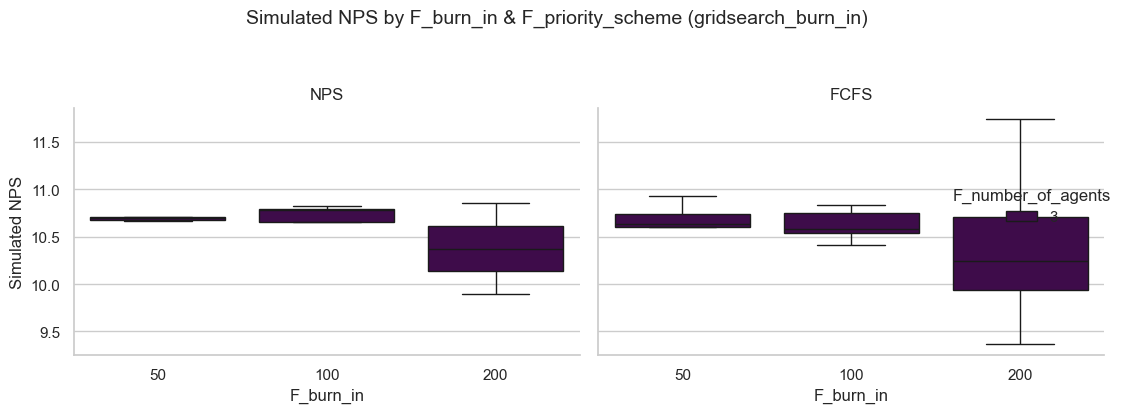

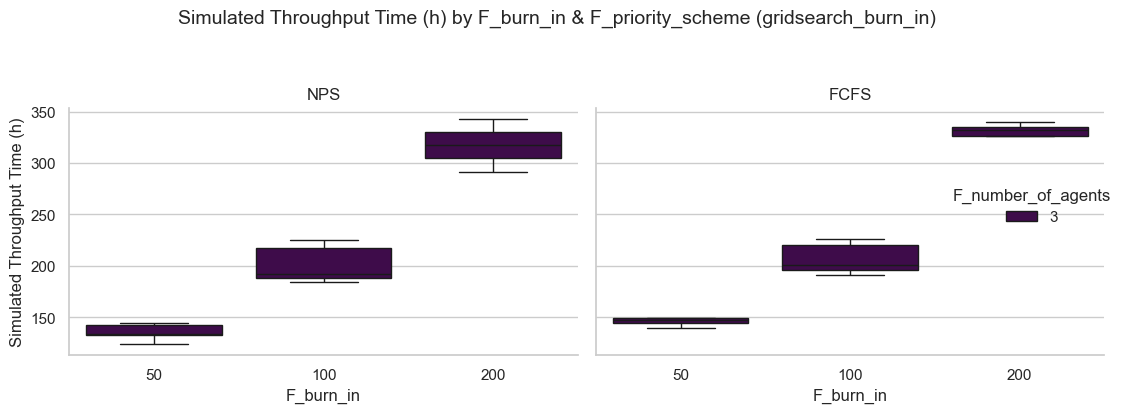

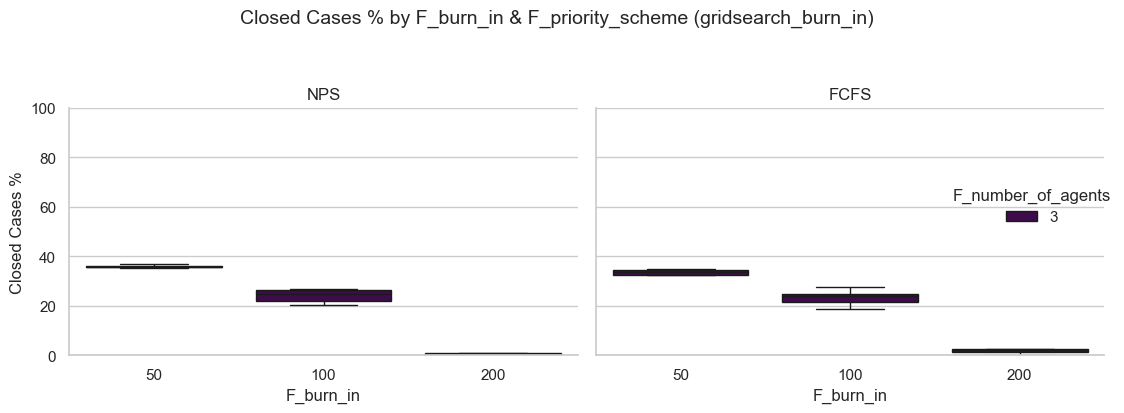

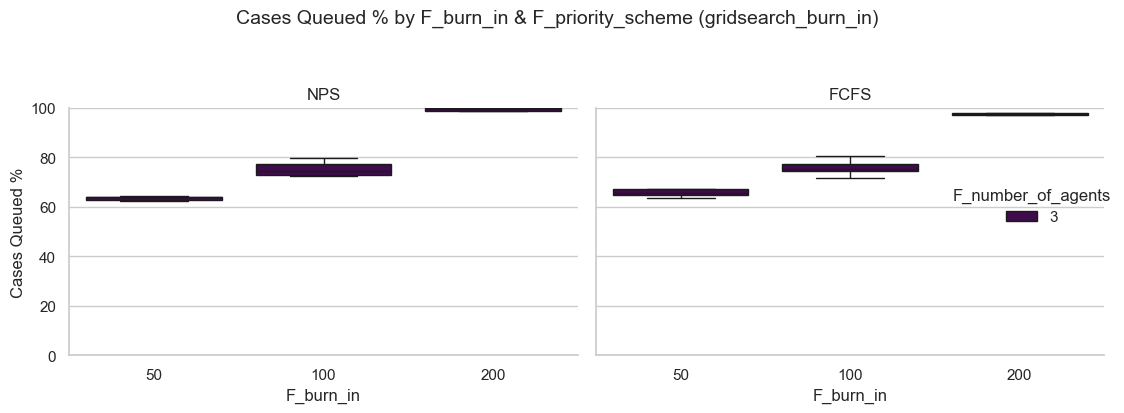

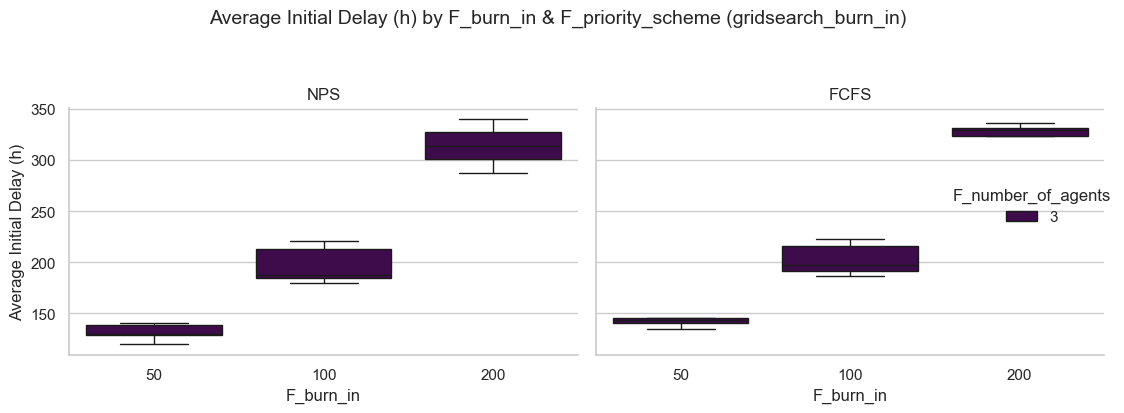

In [26]:
if results_df is not None and not results_df.empty:
    metrics_config_catplot = {
        'closed_avg_simulated_NPS': 'Simulated NPS',
        'closed_avg_simulated_throughput_time': 'Simulated Throughput Time (h)',
        'closed_percent': 'Closed Cases %',
        'case_queued_percent': 'Cases Queued %',
        'closed_avg_initial_delay': 'Average Initial Delay (h)'
    }
    factor_col_burn_in = 'F_burn_in'
    col_facet_col = 'F_priority_scheme'
    hue_col_catplot = 'F_number_of_agents'

    if factor_col_burn_in not in results_df.columns or results_df[factor_col_burn_in].nunique() < 2:
        print(f"Warning: Factor column '{factor_col_burn_in}' is missing or has less than 2 unique values. Skipping these grid plots.")
    elif col_facet_col not in results_df.columns or results_df[col_facet_col].nunique() == 0:
        print(f"Warning: Column '{col_facet_col}' for faceting is missing or has no unique values. Skipping these grid plots.")
    else:
        # Convert F_burn_in to categorical for distinct x-axis points if it's not already
        plot_df_cat = results_df.copy()
        plot_df_cat[factor_col_burn_in] = plot_df_cat[factor_col_burn_in].astype('category')
        # Ensure categories are sorted numerically if possible
        try:
            current_categories = plot_df_cat[factor_col_burn_in].cat.categories
            # Attempt to convert to float for sorting, handle non-numeric gracefully
            sorted_categories = sorted(current_categories, key=lambda x: float(x) if isinstance(x, (int, float, str)) and x.replace('.', '', 1).isdigit() else float('inf'))
            plot_df_cat[factor_col_burn_in] = plot_df_cat[factor_col_burn_in].cat.set_categories(sorted_categories, ordered=True)
        except Exception:
            # Fallback to string sort or default if numeric sort fails
            plot_df_cat[factor_col_burn_in] = plot_df_cat[factor_col_burn_in].cat.reorder_categories(sorted(plot_df_cat[factor_col_burn_in].cat.categories), ordered=True)

        use_hue = hue_col_catplot in plot_df_cat.columns and plot_df_cat[hue_col_catplot].nunique() > 0

        for metric, label in metrics_config_catplot.items():
            if metric not in plot_df_cat.columns or plot_df_cat[metric].isna().all():
                print(f"Warning: Column {metric} not found or all NaN. Skipping grid plot for '{label}'.")
                continue

            g = sns.catplot(
                data=plot_df_cat,
                x=factor_col_burn_in,
                y=metric,
                hue=hue_col_catplot if use_hue else None,
                col=col_facet_col,
                kind='box',
                showfliers=False,
                col_wrap=2, # Adjust as needed, e.g., number of priority schemes / 2
                height=4, aspect=1.2,
                sharey=True, # MODIFIED: Ensures facets of the same metric share y-axis
                palette='viridis'
            )
            g.set_axis_labels(f"{factor_col_burn_in}", label)
            g.set_titles("{col_name}") # Titles for each facet
            g.fig.suptitle(f'{label} by {factor_col_burn_in} & {col_facet_col} ({EXPERIMENT_NAME})', y=1.03, fontsize=14)
            
            # Adjust y-axis limits for specific metrics per facet
            for ax in g.axes.flatten():
                if metric == 'closed_percent' or metric == 'case_queued_percent': 
                    ax.set_ylim(0, 100)
                elif metric == 'closed_avg_initial_delay': 
                    current_ylim_facet = ax.get_ylim()
                    if current_ylim_facet[0] < 0: ax.set_ylim(0, current_ylim_facet[1])
            
            plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust rect for suptitle
            plt.show()
else:
    print("Skipping Metric Comparisons by Burn-in Factor as results_df is not available or empty.")


### 5.3 Data Distributions (Histograms)

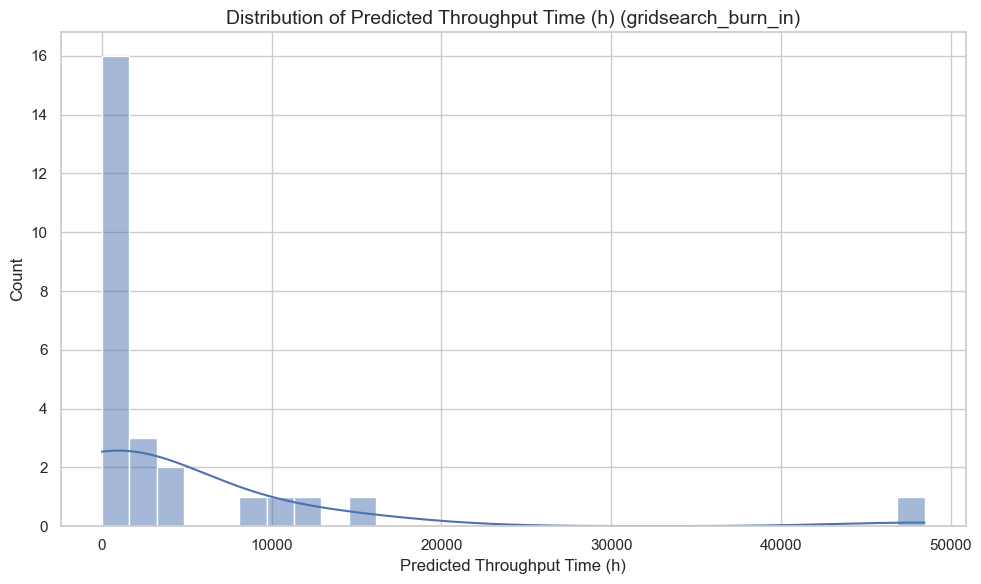

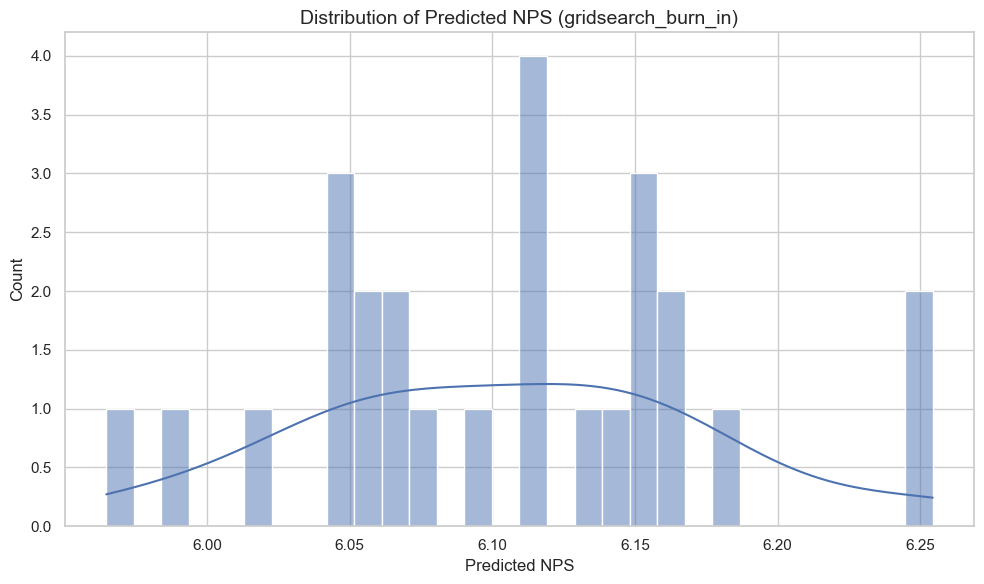

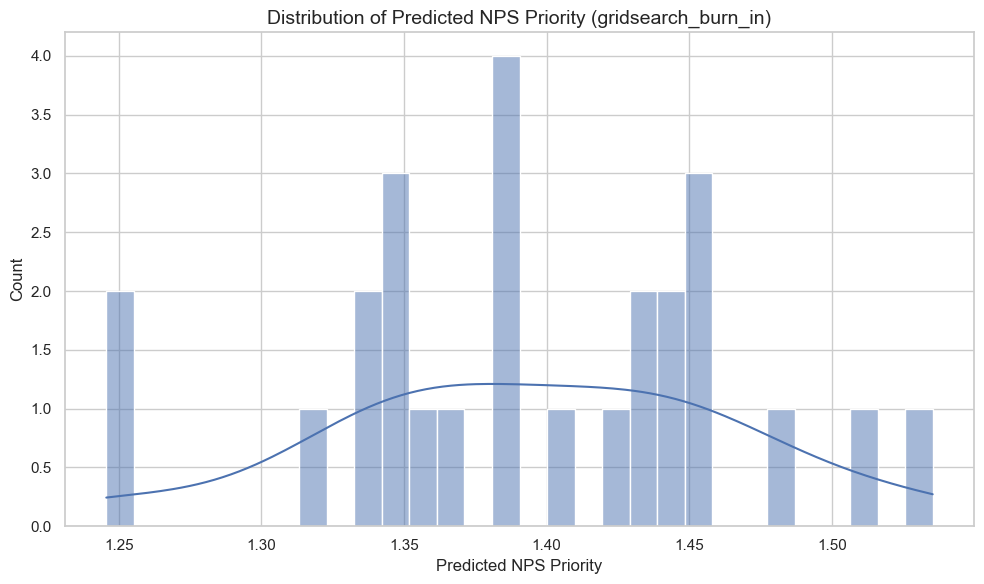

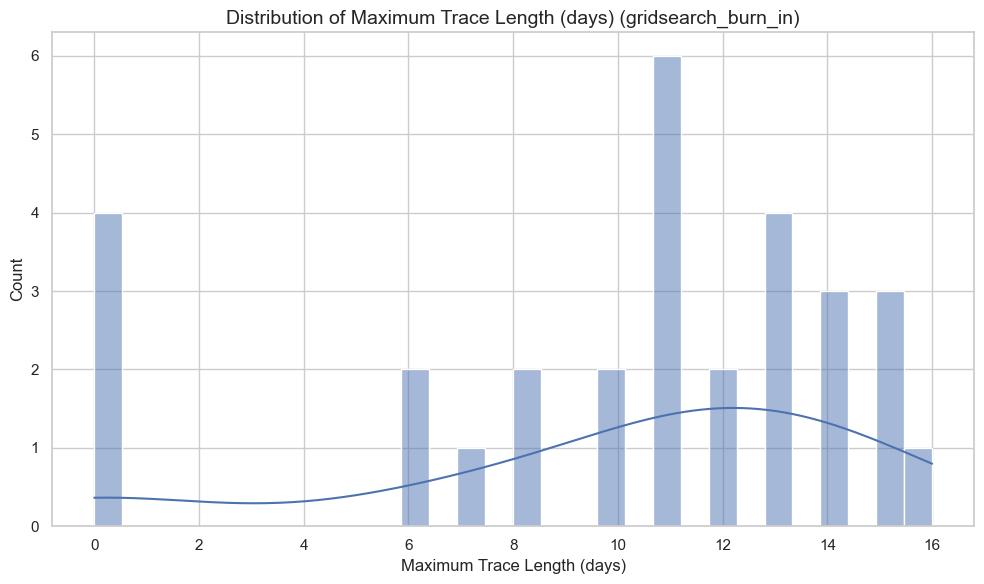

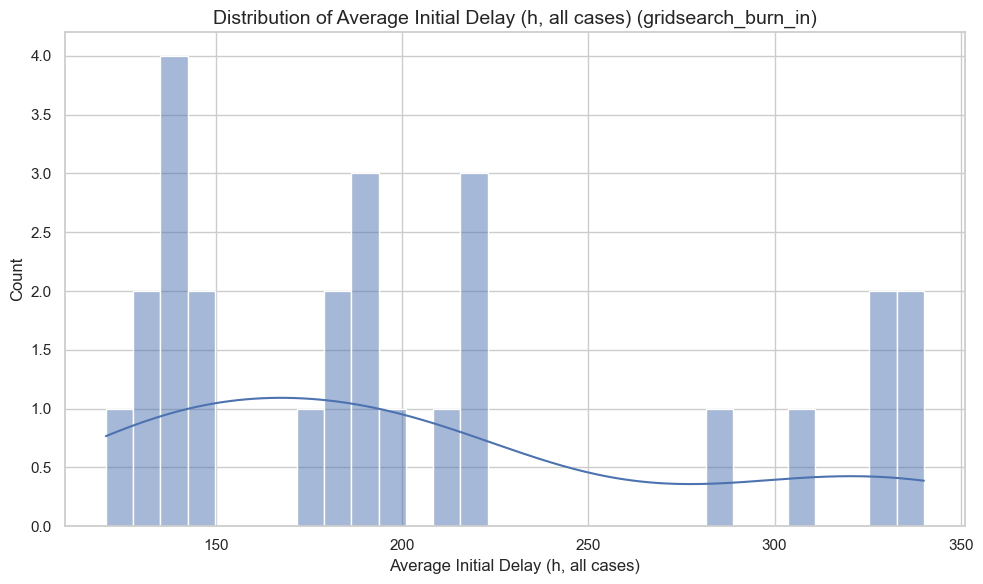

In [20]:
if results_df is not None and not results_df.empty:
    metrics_config_histograms = {
        'closed_avg_predicted_throughput_time': 'Predicted Throughput Time (h)',
        'closed_avg_predicted_NPS': 'Predicted NPS',
        'closed_avg_predicted_NPS_priority': 'Predicted NPS Priority',
        'max_tracelen': 'Maximum Trace Length (days)',
        'all_avg_initial_delay': 'Average Initial Delay (h, all cases)'
    }

    for metric, label in metrics_config_histograms.items():
        if metric not in results_df.columns:
            print(f"Warning: Column {metric} not found. Skipping histogram for '{label}'.")
            continue
        if results_df[metric].isna().all():
            print(f"Warning: Column {metric} is all NaN. Skipping histogram for '{label}'.")
            continue
            
        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=results_df,
            x=metric,
            bins=30,
            kde=True
        )
        plt.title(f'Distribution of {label} ({EXPERIMENT_NAME})', fontsize=14)
        plt.xlabel(label, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        if metric == 'all_avg_initial_delay': 
            current_xlim = plt.gca().get_xlim()
            if current_xlim[0] < 0: plt.xlim(0, current_xlim[1])
        plt.tight_layout()
        plt.show()
else:
    print("Skipping Data Distribution Histograms as results_df is not available or empty.")

### 5.4 Simulated NPS Distribution Details

In [21]:
if results_df is not None and not results_df.empty and 'closed_avg_simulated_NPS' in results_df.columns:
    if 'F_priority_scheme' in results_df.columns:
        print("Summary of Mean Simulated NPS (across runs) by Priority Scheme:")
        priority_order = ['FCFS', 'LRTF', 'SRTF', 'NPS']
        available_schemes_in_data = sorted(results_df['F_priority_scheme'].unique())
        ordered_schemes_for_plot = [s for s in priority_order if s in available_schemes_in_data]
        for s in available_schemes_in_data: # Add any extras not in defined order
            if s not in ordered_schemes_for_plot: ordered_schemes_for_plot.append(s)
            
        nps_summary_stats = results_df.groupby('F_priority_scheme')['closed_avg_simulated_NPS'].agg(['mean', 'std']).reindex(ordered_schemes_for_plot).reset_index()
        display(nps_summary_stats.rename(columns={'mean': 'Mean of Means', 'std': 'Std Dev of Means'}))
    else:
        print("Warning: 'F_priority_scheme' column not found, cannot group for NPS summary statistics.")
else:
    print("Skipping NPS Summary Statistics as results_df is not available, empty, or 'closed_avg_simulated_NPS' column is missing.")

Summary of Mean Simulated NPS (across runs) by Priority Scheme:


,F_priority_scheme,Mean of Means,Std Dev of Means
0,FCFS,10.586980,0.507473
1,NPS,10.645271,0.263453


### 5.5 Regression Analysis

In [22]:
if results_df is not None and not results_df.empty:
    print("--- Starting Regression Analysis ---")
    predictor_cols_numerical = []
    potential_numerical_predictors = ['F_NPS_dist_bias', 'F_tNPS_wtime_effect_bias', 'F_number_of_agents']
    
    for col_name in potential_numerical_predictors:
        if col_name in results_df.columns and pd.to_numeric(results_df[col_name], errors='coerce').nunique() > 1:
            predictor_cols_numerical.append(col_name)
        elif col_name in results_df.columns:
             print(f"Predictor '{col_name}' excluded from regression due to single unique value or non-numeric type.")

    categorical_predictor = None
    if 'F_priority_scheme' in results_df.columns and results_df['F_priority_scheme'].nunique() > 1:
        categorical_predictor = 'F_priority_scheme'
    elif 'F_priority_scheme' in results_df.columns :
        print("Categorical predictor 'F_priority_scheme' excluded due to single unique value.")

    print(f"Numerical predictors for regression: {predictor_cols_numerical}")
    print(f"Categorical predictor for regression: {categorical_predictor}")

    dependent_vars_config_reg = {
        'closed_avg_simulated_throughput_time': 'Simulated Throughput Time',
        'closed_percent': 'Proportion of Closed Cases (%)',
        'closed_avg_simulated_NPS': 'Simulated NPS'
    }

    for dep_var_col, dep_var_label in dependent_vars_config_reg.items():
        print(f"\n--- Regression for: {dep_var_label} ({dep_var_col}) ---")
        if dep_var_col not in results_df.columns or results_df[dep_var_col].isna().all():
            print(f"Skipping regression for '{dep_var_label}' as column '{dep_var_col}' is missing or all NaN.")
            continue
        if results_df[dep_var_col].nunique() < 2:
            print(f"Skipping regression for '{dep_var_label}' as it has less than 2 unique values.")
            continue
        
        current_predictors_numerical = [p for p in predictor_cols_numerical if p in results_df.columns and results_df[p].nunique() > 1]
        current_categorical_predictor = categorical_predictor if categorical_predictor and categorical_predictor in results_df.columns and results_df[categorical_predictor].nunique() > 1 else None
        
        formula_parts = [dep_var_col, "~"]
        final_predictors_in_formula = []
        if current_predictors_numerical:
            final_predictors_in_formula.extend(current_predictors_numerical)
        if current_categorical_predictor:
            final_predictors_in_formula.append(f"C({current_categorical_predictor})")
        
        if not final_predictors_in_formula:
            print(f"No valid predictors found for {dep_var_label}. Skipping this regression.")
            continue
        
        formula = f"{dep_var_col} ~ {' + '.join(final_predictors_in_formula)}"
        print(f"Using formula: {formula}")
        
        try:
            # Ensure dependent variable is numeric and drop NAs for model fitting
            model_df = results_df.copy()
            model_df[dep_var_col] = pd.to_numeric(model_df[dep_var_col], errors='coerce')
            
            cols_to_check_na = [dep_var_col] + current_predictors_numerical
            if current_categorical_predictor: cols_to_check_na.append(current_categorical_predictor)
            model_df.dropna(subset=cols_to_check_na, inplace=True)
            
            if model_df.empty or model_df[dep_var_col].nunique() < 2:
                 print(f"Not enough data or variance in DV '{dep_var_label}' after NA drop. Skipping.")
                 continue
            
            # Check for sufficient observations for the number of predictors
            num_pred_terms = len(current_predictors_numerical) + (model_df[current_categorical_predictor].nunique() -1 if current_categorical_predictor else 0) # k-1 for categorical
            min_obs_needed = num_pred_terms + 1 + 5 # k+1 observations, plus a small margin
            if len(model_df) < min_obs_needed:
                print(f"Skipping regression for '{dep_var_label}' due to insufficient data points ({len(model_df)} found, at least {min_obs_needed} needed for {num_pred_terms} predictor terms) after NA drops.")
                continue
            
            model = smf.ols(formula, data=model_df).fit()
            print(model.summary())
        except Exception as e:
            print(f"Could not perform regression for {dep_var_label}. Error: {e}")
    print("--- Finished Regression Analysis ---")
else:
    print("Skipping Regression Analysis as results_df is not available or empty.")

--- Starting Regression Analysis ---
Predictor 'F_NPS_dist_bias' excluded from regression due to single unique value or non-numeric type.
Predictor 'F_tNPS_wtime_effect_bias' excluded from regression due to single unique value or non-numeric type.
Predictor 'F_number_of_agents' excluded from regression due to single unique value or non-numeric type.
Numerical predictors for regression: []
Categorical predictor for regression: F_priority_scheme

--- Regression for: Simulated Throughput Time (closed_avg_simulated_throughput_time) ---
Using formula: closed_avg_simulated_throughput_time ~ C(F_priority_scheme)
                                     OLS Regression Results                                     
Dep. Variable:     closed_avg_simulated_throughput_time   R-squared:                       0.041
Model:                                              OLS   Adj. R-squared:                  0.001
Method:                                   Least Squares   F-statistic:                     1.020

### 5.6 Impact of Bias Factors on Simulated NPS (Boxplots)

In [23]:
if results_df is not None and not results_df.empty:
    bias_factors_config = {
        'F_tNPS_wtime_effect_bias': 'Simulated NPS by Throughput Time Effect Bias',
        'F_NPS_dist_bias': 'Simulated NPS by Distribution Bias'
    }
    y_metric_bias = 'closed_avg_simulated_NPS'
    hue_column_bias = 'F_priority_scheme'

    if y_metric_bias not in results_df.columns or results_df[y_metric_bias].isna().all():
        print(f"Warning: Column '{y_metric_bias}' is missing or all NaN. Skipping bias factor boxplots.")
    elif hue_column_bias not in results_df.columns or results_df[hue_column_bias].nunique() == 0:
        print(f"Warning: Hue column '{hue_column_bias}' is missing or has no variance. Skipping bias factor boxplots with hue.")
    else:
        for factor_col, title_base in bias_factors_config.items():
            if factor_col not in results_df.columns or results_df[factor_col].nunique() < 2:
                print(f"Warning: Factor column '{factor_col}' is missing or has no variance. Skipping boxplot for this factor.")
                continue
            
            plot_data_bias = results_df.copy()
            # Convert factor_col to string then category for discrete treatment and ordering
            plot_data_bias[factor_col] = plot_data_bias[factor_col].astype(str).astype('category')
            try: # Try numeric sort for categories
                # Attempt to convert categories to float for sorting, handle non-numeric gracefully
                sorted_categories = sorted(plot_data_bias[factor_col].cat.categories, 
                                         key=lambda x: float(x) if isinstance(x, (int, float)) or (isinstance(x, str) and x.replace('.', '', 1).isdigit()) else float('inf'))
                plot_data_bias[factor_col] = plot_data_bias[factor_col].cat.set_categories(sorted_categories, ordered=True)
            except Exception: # Fallback to string sort
                plot_data_bias[factor_col] = plot_data_bias[factor_col].cat.reorder_categories(sorted(plot_data_bias[factor_col].cat.categories), ordered=True)
            
            # Ensure hue column is string and get hue_order
            plot_data_bias[hue_column_bias] = plot_data_bias[hue_column_bias].astype(str)
            hue_order_bias = sorted(plot_data_bias[hue_column_bias].unique())
            
            plt.figure(figsize=(13, 7))
            sns.boxplot(
                data=plot_data_bias,
                x=factor_col,
                y=y_metric_bias,
                hue=hue_column_bias,
                hue_order=hue_order_bias,
                palette='viridis',
                showfliers=False
            )
            plt.title(f'{title_base} ({EXPERIMENT_NAME})', fontsize=15, pad=10)
            plt.xlabel(factor_col, fontsize=13)
            plt.ylabel('Average Simulated NPS (per run)', fontsize=13)
            if len(plot_data_bias[factor_col].cat.categories) > 5 : plt.xticks(rotation=45, ha="right")
            plt.legend(title=hue_column_bias, bbox_to_anchor=(1.02, 1), loc='upper left')
            plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust rect to make space for legend 
            plt.show()
else:
    print("Skipping Bias Factor Boxplots as results_df is not available or empty.")

## 6. Original Notebook Sections (Review and Retain/Remove as Needed)

### (Original) 3.1 Define Subsetting Criteria
This section can be kept if you still need manual subsetting capabilities beyond the `Done==1` filter.

In [24]:
# --- Configuration for Subsetting (Original Notebook Section) ---
APPLY_MANUAL_SUBSET = False # Set to True to apply additional manual filters

# Example: Filter by specific priority rules (if not already handled by experiment design)
INCLUDE_RULES_MANUAL = ['FCFS', 'SRTF', 'LRTF', 'NPS'] 
# -------------------------------------

if APPLY_MANUAL_SUBSET and results_df is not None and not results_df.empty:
    print("Applying manual subsets...")
    if 'F_priority_scheme' in results_df.columns:
        original_rows = len(results_df)
        results_df_manual_subset = results_df[results_df['F_priority_scheme'].isin(INCLUDE_RULES_MANUAL)].copy() # Operate on a copy
        print(f"Filtered results_df by F_priority_scheme. Rows reduced from {original_rows} to {len(results_df_manual_subset)}.")
        # Add other manual filters as needed to results_df_manual_subset
        display(results_df_manual_subset.head()) # Show sample after manual subsetting
    else:
        print("'F_priority_scheme' column not found for manual subsetting.")
elif results_df is not None and not results_df.empty:
    print("Manual subsetting is currently turned OFF.")
else:
    print("Skipping manual subsetting as results_df is not available.")

Manual subsetting is currently turned OFF.


### (Original) 5. Further Analysis (Add your own)
This is a good place for any ad-hoc analyses or explorations not covered by the standardized report.

In [25]:
# Placeholder for your custom analyses (Original Notebook Section)
if results_df is not None and not results_df.empty:
    print("Ready for further custom analysis on results_df.")
    # Example: Describe a specific column
    # if 'closed_avg_simulated_NPS' in results_df.columns:
    #     print(results_df['closed_avg_simulated_NPS'].describe())
else:
    print("results_df not available for further custom analysis.")

Ready for further custom analysis on results_df.


---